# 多臂老虎机问题

## 多臂老虎机模型

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 老虎机模型
class BernoulliBandit:
    def __init__(self, K):
        self.probs = np.random.uniform(size=K)  # 随机生成K个0～1的数,作为每根拉杆的实际获奖概率
        self.best_idx = np.argmax(self.probs)
        self.best_prob = self.probs[self.best_idx]
        self.K = K

    def step(self, k):
        # 定义奖励
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0

np.random.seed(1)
bandit = BernoulliBandit(10)
print(bandit.best_idx, bandit.best_prob)
print(bandit.probs)

In [ ]:
# 多臂老虎机算法的基本框架
class Solver:
    def __init__(self, bandit):
        self.bandit  = bandit
        self.counts = np.zeros(bandit.K) # 记录每个杆被拉了多少次
        self.regret = 0.0
        self.actions = [] # 记录每一步采取的动作
        self.regrets = [] # 记录的是累计懊悔
    
    def update_regret(self, k):
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    # 各个策略决策出来的下一步拉哪个杆
    def run_one_step(self):
        raise NotImplementedError # 如果子类没有实现这个方法，父类会使用这个语句抛出异常
    
    # 定义每次策略的更新
    def run(self, num_steps):
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] +=1 # 更新计数器
            self.actions.append(k)
            self.update_regret(k)

## epsilon贪婪策略

In [ ]:
# 贪婪策略 需要继承Solver
class EpsilonGreedy(Solver):
    def __init__(self, bandit, epsilon=0.01):
        super().__init__(bandit) # 调用父类的构造函数并传入参数bandit
        self.epsilon = epsilon
        self.estimates = np.array([1.0] * self.bandit.K) # 初始化期望奖励
    
    def run_one_step(self):
        # 以一定概率取最大期望奖励的杆,epsilon是探索概率
        if np.random.rand() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)
        r = self.bandit.step(k) # 获取本次奖励并更新期望奖励
        # 先更新计数器再更新期望奖励，但代码中是先选择出动作，再更新计数器，因此这里counts+1
        # 1. / a 结果始终为浮点数
        self.estimates[k] +=  1. / (self.counts[k] + 1) *(r - self.estimates[k]) 
        return k

In [ ]:
# 绘图 solver是各个参数或者策略下的算法解决器，都继承了Solver类
def plot_results(solvers, solver_names):
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('time steps')
    plt.ylabel('cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

### 不变epsilon  

In [ ]:
np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit)
epsilon_greedy_solver.run(5000)
plot_results([epsilon_greedy_solver], ["epsilon=0.01"])

In [ ]:
# 多种epsilon取值
np.random.seed(0)
epsilon_list = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [EpsilonGreedy(bandit, epsilon=e) for e in epsilon_list]
epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in epsilon_list]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)
# 最终epsilon越大，累计懊悔越大
plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

### 衰减epsilon

In [ ]:
class DecayingEpsilonGreedy(Solver):
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)
        
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])

        return k

np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit)
decaying_epsilon_greedy_solver.run(5000)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

## UCB算法

In [ ]:
class UCB(Solver):
    def __init__(self, bandit, coef):
        super().__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([1.0] * self.bandit.K)
        self.coef = coef # 不确定性比重系数c
    
    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(np.log(self.total_count) / (2 * self.counts + 1)) # 1*10个数据的ucb
        k = np.argmax(ucb)
        r = self.bandit.step(k)
        # 估计更新
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k]) 
        return k
    
np.random.seed(1)
UCB_solver = UCB(bandit, 1)
UCB_solver.run(5000)
np.set_printoptions(precision=3, suppress=True) # 输出numpy数组控制精度并不以科学计数法
# 结果对最优奖励估计得比较准确
print(UCB_solver.bandit.probs, UCB_solver.estimates)
plot_results([UCB_solver], ["UCB"])


## 汤普森采样

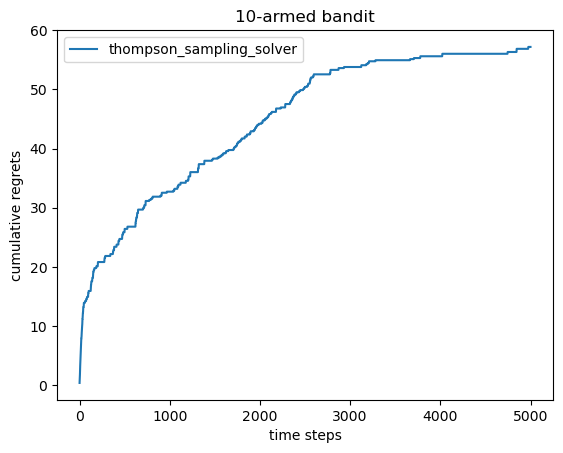

In [29]:
class ThompsonSampling(Solver):
    def __init__(self, bandit):
        super().__init__(bandit)
        self._a = np.ones(self.bandit.K)
        self._b = np.ones(self.bandit.K)

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)
        k = np.argmax(samples)
        r = self.bandit.step(k)
        self._a[k] += r
        self._b[k] += (1-r)
        return k

np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit)
thompson_sampling_solver.run(5000)
np.set_printoptions(precision=3, suppress=True)
plot_results([thompson_sampling_solver], ["thompson_sampling_solver"])
